# 1 Preparing the data from kaggle

In [0]:
!pip install -q kaggle

## 1.1 Upload kaggle API key file

In [0]:
from google.colab import files
uploaded = files.upload()

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
rm -r /root/.kaggle/

rm: cannot remove '/root/.kaggle/': No such file or directory


In [0]:
!mkdir /root/.kaggle 

In [0]:
mv kaggle.json /root/.kaggle/

## 1.2 Download the data

In [5]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.19G/5.20G [02:25<00:00, 39.5MB/s]
100% 5.20G/5.20G [02:25<00:00, 38.3MB/s]


In [6]:
!unzip skin-cancer-mnist-ham10000.zip && rm skin-cancer-mnist-ham10000.zip

Archive:  skin-cancer-mnist-ham10000.zip
  inflating: HAM10000_images_part_1/ISIC_0024306.jpg  
  inflating: HAM10000_images_part_1/ISIC_0024307.jpg  
  inflating: HAM10000_images_part_1/ISIC_0024308.jpg  
  inflating: HAM10000_images_part_1/ISIC_0024309.jpg  
  inflating: HAM10000_images_part_1/ISIC_0024310.jpg  
  inflating: HAM10000_images_part_1/ISIC_0024311.jpg  
  inflating: HAM10000_images_part_1/ISIC_0024312.jpg  
  inflating: HAM10000_images_part_1/ISIC_0024313.jpg  
  inflating: HAM10000_images_part_1/ISIC_0024314.jpg  
  inflating: HAM10000_images_part_1/ISIC_0024315.jpg  
  inflating: HAM10000_images_part_1/ISIC_0024316.jpg  
  inflating: HAM10000_images_part_1/ISIC_0024317.jpg  
  inflating: HAM10000_images_part_1/ISIC_0024318.jpg  
  inflating: HAM10000_images_part_1/ISIC_0024319.jpg  
  inflating: HAM10000_images_part_1/ISIC_0024320.jpg  
  inflating: HAM10000_images_part_1/ISIC_0024321.jpg  
  inflating: HAM10000_images_part_1/ISIC_0024322.jpg  
  inflating: HAM10000_im

# 2 Importing libraries

In [0]:
import os
from glob import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

# 3 Analysing the data

## 3.1 Read the dataset

In [0]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
base_loc = './'
image_paths = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(base_loc, '*', '*.jpg'))}

In [0]:
data = pd.read_csv('HAM10000_metadata.csv')
data['lesion_type'] = data['dx'].map(lesion_type_dict.get)
#data['lesion_type_id'] = pd.Categorical(data['lesion_type']).codes
data['image_path'] = data['image_id'].map(image_paths.get)

## 3.2 Exploratory Data Analysis

In [76]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 9 columns):
lesion_id       10015 non-null object
image_id        10015 non-null object
dx              10015 non-null object
dx_type         10015 non-null object
age             9958 non-null float64
sex             10015 non-null object
localization    10015 non-null object
lesion_type     10015 non-null object
image_path      10015 non-null object
dtypes: float64(1), object(8)
memory usage: 704.3+ KB


In [77]:
data.describe()

,age
count,9958.000000
mean,51.863828
std,16.968614
min,0.000000
25%,40.000000
50%,50.000000
75%,65.000000
max,85.000000


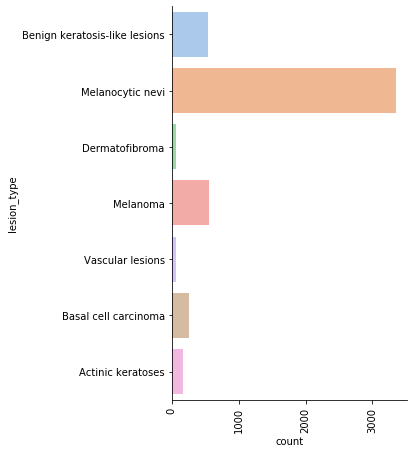

In [78]:
chart = sns.catplot(palette="pastel", y="lesion_type", kind="count",data=data, height=6, aspect=1)
chart.set_xticklabels(rotation=90)

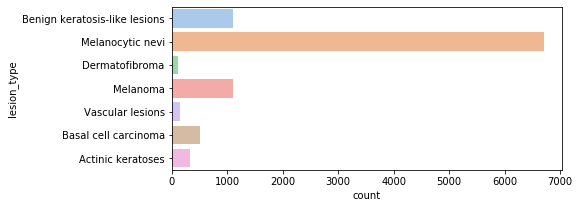

In [79]:
f, ax = plt.subplots(figsize=(7, 3))
sns.countplot(y="lesion_type", data=data, palette="pastel");

## Alterações começam aqui >>


In [80]:
print(data['lesion_type'].value_counts())

Melanocytic nevi                 6705
Melanoma                         1113
Benign keratosis-like lesions    1099
Basal cell carcinoma              514
Actinic keratoses                 327
Vascular lesions                  142
Dermatofibroma                    115
Name: lesion_type, dtype: int64


In [81]:
df_Melanocytic = data[data['lesion_type'] == 'Melanocytic nevi']
df_Melanocytic = df_Melanocytic.iloc[:521]


df_Benign_keratosis_lesions = data[data['lesion_type'] == 'Benign keratosis-like lesions']
df_Benign_keratosis_lesions = df_Benign_keratosis_lesions.iloc[:521]

#df_Basal_cell_carcinoma = data[data['lesion_type'] == 'Basal cell carcinoma']
#df_Basal_cell_carcinoma = df_Basal_cell_carcinoma.iloc[:215]

#df_Actinic_keratoses = data[data['lesion_type'] == 'Actinic keratoses']
#df_Actinic_keratoses = df_Actinic_keratoses.iloc[:215]

data = data.loc[~((data['lesion_type']=='Benign keratosis-like lesions') | (data['lesion_type']=='Melanocytic nevi') | (
    data['lesion_type'] =='Basal cell carcinoma') | (data['lesion_type'] =='Actinic keratoses'
))]

data = pd.concat([data, df_Melanocytic, df_Benign_keratosis_lesions, df_Basal_cell_carcinoma, df_Actinic_keratoses])
print(data['lesion_type'].value_counts())

Melanoma                         1113
Benign keratosis-like lesions     521
Melanocytic nevi                  521
Basal cell carcinoma              215
Actinic keratoses                 215
Vascular lesions                  142
Dermatofibroma                    115
Name: lesion_type, dtype: int64


In [82]:
data['lesion_type'] = data['lesion_type'].map({'Melanocytic nevi':'benign', 'Benign keratosis-like lesions': 'benign', 'Basal cell carcinoma':'malign',
                                            'Actinic keratoses':'benign', 'Vascular lesions':'benign', 'Dermatofibroma':'benign', 'Melanoma':'malign'})
data['lesion_type_id'] = pd.Categorical(data['lesion_type']).codes
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,lesion_type,image_path,lesion_type_id
1095,HAM_0005276,ISIC_0027008,df,histo,75.0,male,back,benign,./HAM10000_images_part_1/ISIC_0027008.jpg,0
1096,HAM_0005276,ISIC_0028790,df,histo,75.0,male,back,benign,./HAM10000_images_part_1/ISIC_0028790.jpg,0
1097,HAM_0004103,ISIC_0028880,df,histo,55.0,male,lower extremity,benign,./HAM10000_images_part_1/ISIC_0028880.jpg,0
1098,HAM_0004103,ISIC_0031309,df,histo,55.0,male,lower extremity,benign,./HAM10000_images_part_2/ISIC_0031309.jpg,0
1099,HAM_0001164,ISIC_0030021,df,histo,50.0,female,upper extremity,benign,./HAM10000_images_part_2/ISIC_0030021.jpg,0


In [83]:
print(data['lesion_type'].value_counts())

benign    1514
malign    1328
Name: lesion_type, dtype: int64


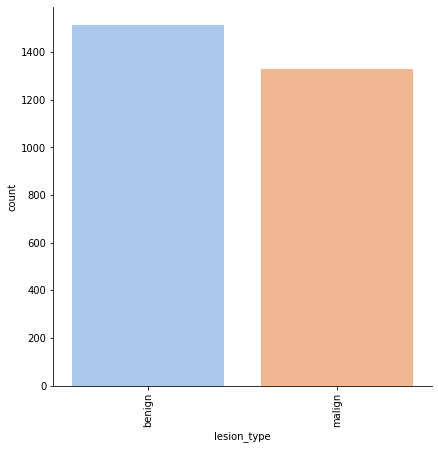

In [84]:
chart = sns.catplot(x="lesion_type", kind="count",data=data, height=6, aspect=1, palette="pastel")
chart.set_xticklabels(rotation=90)

## Alterações terminam aqui <<

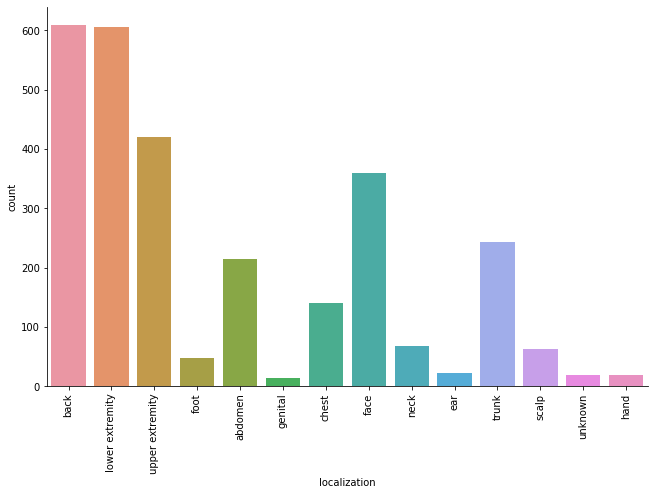

In [85]:
chart = sns.catplot(x="localization", kind="count",data=data, height=6, aspect=1.5)
chart.set_xticklabels(rotation=90)

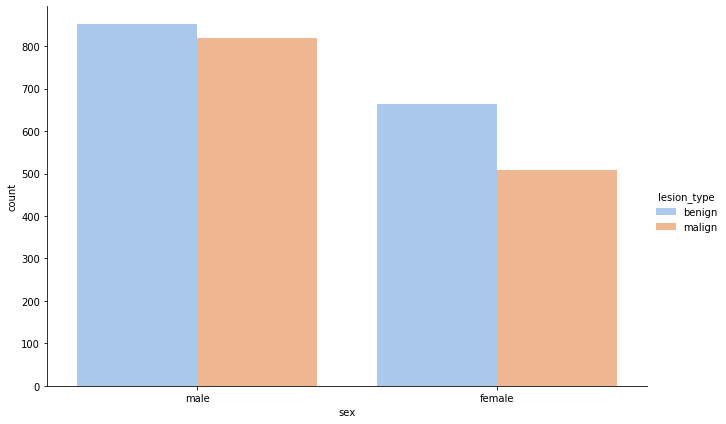

In [86]:
sns.catplot(x="sex",  palette="pastel",
                hue="lesion_type",
                data=data, kind="count",
                height=6, aspect=1.5)

## 3.3 Clean and prepare data

In [0]:
data['age'].fillna((data['age'].mean()), inplace=True)

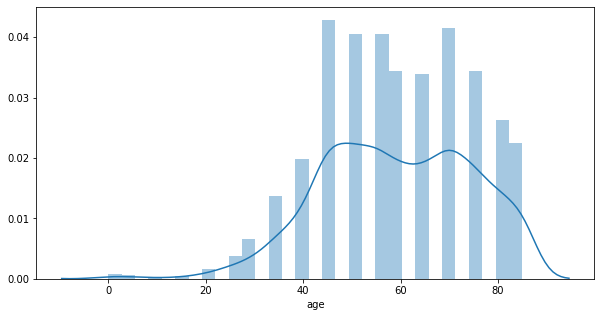

In [88]:
plt.figure(figsize=(10,5))
sns.distplot(data.age)

## 3.4 Getting images

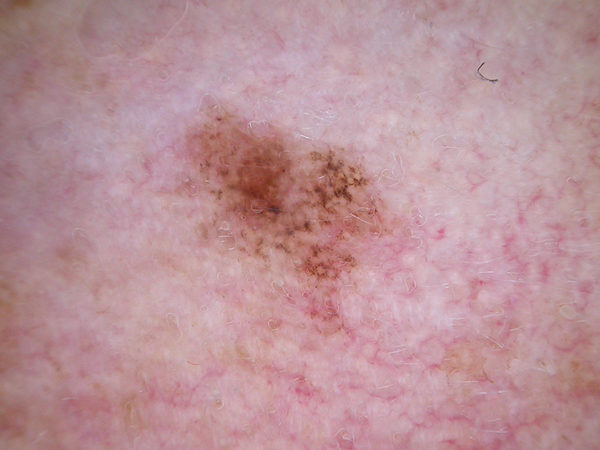

In [89]:
sample_image_path = data.sample()['image_path'].values[0]
Image.open(sample_image_path)

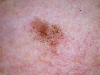

In [90]:
Image.open(sample_image_path).resize((100,75))

In [0]:
data['image'] = data['image_path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [92]:
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,lesion_type,image_path,lesion_type_id,image
1095,HAM_0005276,ISIC_0027008,df,histo,75.0,male,back,benign,./HAM10000_images_part_1/ISIC_0027008.jpg,0,"[[[157, 113, 102], [169, 128, 126], [178, 135,..."
1096,HAM_0005276,ISIC_0028790,df,histo,75.0,male,back,benign,./HAM10000_images_part_1/ISIC_0028790.jpg,0,"[[[211, 160, 167], [214, 167, 177], [218, 165,..."
1097,HAM_0004103,ISIC_0028880,df,histo,55.0,male,lower extremity,benign,./HAM10000_images_part_1/ISIC_0028880.jpg,0,"[[[219, 190, 220], [220, 191, 219], [220, 192,..."
1098,HAM_0004103,ISIC_0031309,df,histo,55.0,male,lower extremity,benign,./HAM10000_images_part_2/ISIC_0031309.jpg,0,"[[[25, 18, 26], [46, 33, 42], [64, 44, 55], [8..."
1099,HAM_0001164,ISIC_0030021,df,histo,50.0,female,upper extremity,benign,./HAM10000_images_part_2/ISIC_0030021.jpg,0,"[[[197, 155, 159], [199, 158, 166], [200, 158,..."


In [93]:
#ALTERACAO
data.loc[data['lesion_type'] == 'benign', 'lesion_type_id'] = 0
data.loc[data['lesion_type'] == 'malign', 'lesion_type_id'] = 1
data.head()
#ALTERACAO

,lesion_id,image_id,dx,dx_type,age,sex,localization,lesion_type,image_path,lesion_type_id,image
1095,HAM_0005276,ISIC_0027008,df,histo,75.0,male,back,benign,./HAM10000_images_part_1/ISIC_0027008.jpg,0,"[[[157, 113, 102], [169, 128, 126], [178, 135,..."
1096,HAM_0005276,ISIC_0028790,df,histo,75.0,male,back,benign,./HAM10000_images_part_1/ISIC_0028790.jpg,0,"[[[211, 160, 167], [214, 167, 177], [218, 165,..."
1097,HAM_0004103,ISIC_0028880,df,histo,55.0,male,lower extremity,benign,./HAM10000_images_part_1/ISIC_0028880.jpg,0,"[[[219, 190, 220], [220, 191, 219], [220, 192,..."
1098,HAM_0004103,ISIC_0031309,df,histo,55.0,male,lower extremity,benign,./HAM10000_images_part_2/ISIC_0031309.jpg,0,"[[[25, 18, 26], [46, 33, 42], [64, 44, 55], [8..."
1099,HAM_0001164,ISIC_0030021,df,histo,50.0,female,upper extremity,benign,./HAM10000_images_part_2/ISIC_0030021.jpg,0,"[[[197, 155, 159], [199, 158, 166], [200, 158,..."


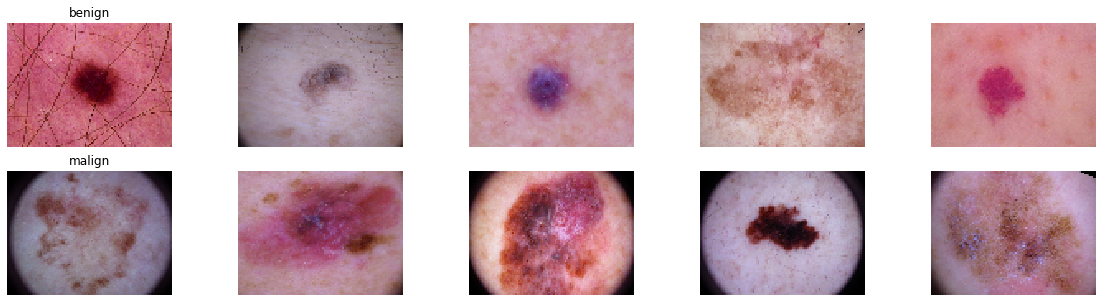

In [95]:
n_samples = 5
fig, m_axs = plt.subplots(2, n_samples, figsize = (4*n_samples, 5))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         data.sort_values(['lesion_type']).groupby('lesion_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=42).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

# 4 Modeling

In [0]:
seed = 42
input_shape = (75, 100, 3)
num_classes = 2 #7
num_epochs = 64
batch_size = 10

## 4.1 Spliting the data

In [0]:
X = data.drop(columns='lesion_type_id')
y = data['lesion_type_id'].copy()

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed, stratify=y)

In [0]:
X_train = np.asarray(X_train['image'].tolist())
X_test = np.asarray(X_test['image'].tolist())

X_train = (X_train - X_train.mean())/X_train.std()
X_test = (X_test - X_test.mean())/X_test.std()

In [0]:
y_train = to_categorical(y_train, num_classes= 2) #7
y_test = to_categorical(y_test, num_classes= 2) #7

## 4.2 Creating the model

In [101]:
model = Sequential([
    Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', input_shape=input_shape),
    Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size= (2, 2)),
    Dropout(0.25),

    Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'),
    Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size= (2, 2)),
    Dropout(0.25),

    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(pool_size= (2, 2)),
    Dropout(0.5),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [102]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 75, 100, 32)       896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 100, 32)       9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 37, 50, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 37, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 50, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 25, 64)        0

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## 4.3 Test

In [104]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

Train on 2273 samples, validate on 569 samples
Epoch 1/20
2273/2273 [==============================] - 96s 42ms/sample - loss: 0.6953 - acc: 0.5873 - val_loss: 0.6347 - val_acc: 0.6766
Epoch 2/20
2273/2273 [==============================] - 96s 42ms/sample - loss: 0.5872 - acc: 0.6700 - val_loss: 0.5961 - val_acc: 0.6837
Epoch 3/20
2273/2273 [==============================] - 96s 42ms/sample - loss: 0.5673 - acc: 0.6929 - val_loss: 0.6482 - val_acc: 0.6028
Epoch 4/20
2273/2273 [==============================] - 96s 42ms/sample - loss: 0.6409 - acc: 0.6313 - val_loss: 0.5703 - val_acc: 0.6889
Epoch 5/20
2273/2273 [==============================] - 96s 42ms/sample - loss: 0.5839 - acc: 0.7017 - val_loss: 0.5737 - val_acc: 0.6907
Epoch 6/20
2273/2273 [==============================] - 96s 42ms/sample - loss: 0.5410 - acc: 0.7202 - val_loss: 0.5442 - val_acc: 0.7329
Epoch 7/20
2273/2273 [==============================] - 96s 42ms/sample - loss: 0.5242 - acc: 0.7325 - val_loss: 0.5107 - val

In [106]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

569/569 [==============================] - 6s 10ms/sample - loss: 0.5093 - acc: 0.7680
Test: accuracy = 0.768014  ;  loss = 0.509314


In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'test'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'test'], loc='best')
    plt.show()

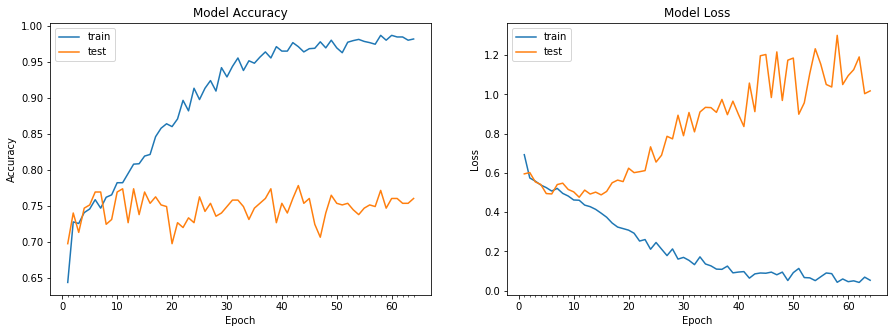

In [0]:
plot_model_history(history)